# Background

In this project we'll build a SMS spam detection model. We'll be using the SMS spam dataset from the Kaggle website for this project:

https://www.kaggle.com/uciml/sms-spam-collection-dataset/data

Let's start by importing the required libraries

In [68]:
from six.moves import urllib
import zipfile
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import (TfidfVectorizer, CountVectorizer,
                                             ENGLISH_STOP_WORDS)
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from wordcloud import WordCloud
from matplotlib import pyplot as plt

The compressed dataset has been saved in the working directory and now just needs to be extracted and read into Python

In [255]:
ZIP_FOLDER = "sms-spam-collection-dataset.zip"

with zipfile.ZipFile(ZIP_FOLDER, "r") as z:
    z.extractall()

In [2]:
df = pd.read_csv("spam.csv",encoding = 'ISO-8859-1')

In [3]:
nobs = df.shape[0]

Let's have a look at the data

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


We see there are some nonsensical columns that can be dropped

In [266]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [5]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)

We'll also rename the columns to more meaningful names and encode the outcome variable (whether the SMS is spam or ham) to 1 for spam and 0 for ham.

In [6]:
df.columns = ['labels','data']

In [7]:
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

We can create a word cloud of our data to see which words appear more frequently in the ham and spam SMSs

In [8]:
def visualize(label):
    words = ''
    for msg in df[df['labels'] == label]['data']:
        msg = msg.lower()
        words += msg + ' '
    wordcloud = WordCloud(width=600,height=400).generate(words)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

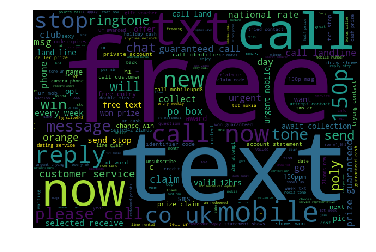

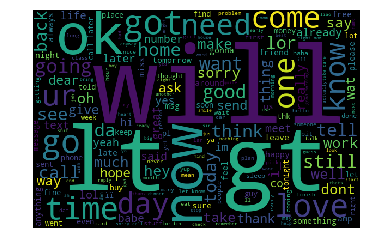

In [320]:
visualize('spam')
visualize('ham')

The words that dominate in spam SMSs are: text, free, call and now. 

Next we'll split out dataset into a training and test set 

In [9]:
train_set, test_set = train_test_split(df, test_size=0.33,random_state=8943)

In [10]:
X_train = train_set.drop(['b_labels','labels'],axis=1)
y_train = train_set['b_labels'].copy()

X_test = test_set.drop(['b_labels','labels'],axis=1)
y_test = test_set['b_labels'].copy()

Next we'll make use of the CountVectorizer function to count the number of times a word appear in the message

In [37]:
class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        return X[self.attribute_names].values

In [38]:
first_pipeline = Pipeline([
    ('selector', DataFrameSelector('data')),
    ('count_vector', CountVectorizer(decode_error='ignore'))
])

And now we're ready to fit our first model

In [63]:
data_prepared = first_pipeline.fit_transform(X_train)

In [64]:
model = MultinomialNB()
NB_model_1 = model.fit(data_prepared,y_train)

Let's see what the accuracy rates are on the training and test sets

In [41]:
print('Train Accuracy rate: {:1.2f}'.format(NB_model_1.score(data_prepared,y_train)))

Train Accuracy rate: 0.99


Let's see why some of the SMSs were flagged as not spam while in actual fact it was spam

In [16]:
predictions = model.predict(data_prepared)

In [17]:
df2 = pd.DataFrame({'data': X_train['data'], 'b_labels': y_train, 'predictions': predictions})

In [18]:
sneaky_spam = (df2[(df2['predictions'] == 0) & 
                        (df2['b_labels'] == 1)]['data'])

In [19]:
for msg in sneaky_spam:
    print(msg)

Oh my god! I've found your number again! I'm so glad, text me back xafter this msgs cst std ntwk chg å£1.50
LIFE has never been this much fun and great until you came in. You made it truly special for me. I won't forget you! enjoy @ one gbp/sms
Babe: U want me dont u baby! Im nasty and have a thing 4 filthyguys. Fancy a rude time with a sexy bitch. How about we go slo n hard! Txt XXX SLO(4msgs)
Hello. We need some posh birds and chaps to user trial prods for champneys. Can i put you down? I need your address and dob asap. Ta r
Hi babe its Chloe, how r u? I was smashed on saturday night, it was great! How was your weekend? U been missing me? SP visionsms.com Text stop to stop 150p/text
2/2 146tf150p
Missed call alert. These numbers called but left no message. 07008009200
ROMCAPspam Everyone around should be responding well to your presence since you are so warm and outgoing. You are bringing in a real breath of sunshine.
dating:i have had two of these. Only started after i sent a text t

Let's do the same for SMSs that were flagged as spam while in fact not

In [20]:
not_actually_spam = df2[(df2['predictions'] == 1) & (df2['b_labels'] == 0)]['data']

In [21]:
for msg in not_actually_spam:
    print(msg)

Waiting for your call.
No pic. Please re-send.
Total video converter free download type this in google search:)
Garbage bags, eggs, jam, bread, hannaford wheat chex
I liked the new mobile
Unlimited texts. Limited minutes.
Gettin rdy to ship comp


Next we'll calculate the term-frequency times inverse document-frequency and include it in the model to see what it has on the predictive power

In [42]:
second_pipeline = Pipeline([
    ('selector', DataFrameSelector('data')),
    ('count_vector', TfidfVectorizer(decode_error='ignore'))
])

In [43]:
data_prepared = second_pipeline.fit_transform(X_train)

In [44]:
NB_model_2 = model.fit(data_prepared,y_train)

In [45]:
print('Train Accuracy rate: {:1.2f}'.format(NB_model_2.score(data_prepared,y_train)))

Train Accuracy rate: 0.97


There is now a slight deterioration in the model. Next we'll remove the stopwords.Stopwords are those words in natural language which carry no own meaning and serve the purpose of connecting other words together to create grammatical sentences. They are essential components of grammar and needed for effective communication, but do not have semantic significance. 

In [46]:
third_pipeline = Pipeline([
    ('selector', DataFrameSelector('data')),
    ('count_vector', TfidfVectorizer(decode_error='ignore',stop_words=ENGLISH_STOP_WORDS))
])

In [47]:
data_prepared = third_pipeline.fit_transform(X_train)

In [48]:
NB_model_3 = model.fit(data_prepared,y_train)

In [49]:
print('Train Accuracy rate: {:1.2f}'.format(NB_model_3.score(data_prepared,y_train)))

Train Accuracy rate: 0.98


Let's create a new feature containing the length of the message

In [30]:
class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
   
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        df = X_train.copy()
        nobs = df.shape[0]
        df['len'] = df['data'].str.len()
        
        len_array = np.array(df['len']).reshape((nobs,1))
        return np.concatenate((X.toarray(),len_array), axis=1)

In [50]:
fourth_pipeline = Pipeline([
    ('selector', DataFrameSelector('data')),
    ('count_vector', TfidfVectorizer(decode_error='ignore',stop_words=ENGLISH_STOP_WORDS)),
    ('attribs_adder', CombinedAttributesAdder())
])


In [51]:
data_prepared = fourth_pipeline.fit_transform(X_train)

In [52]:
NB_model_4 = model.fit(data_prepared,y_train)

In [53]:
print('Train Accuracy rate: {:1.2f}'.format(NB_model_4.score(data_prepared,y_train)))

Train Accuracy rate: 0.87


The test acuracy has dropped significantly. So the lenght of the message isn't deemed a important. Finally we can test our best performing model on our test set

In [65]:
test_data_prepared = first_pipeline.transform(X_test)

In [66]:
predictions = NB_model_1.predict(test_data_prepared)

In [70]:
print('Test Accuracy rate: {:1.2f}'.format(accuracy_score(y_test,predictions)))


Test Accuracy rate: 0.98
